<h2 style="font-family: 'Helvetica'; font-size: 30px; color: #89CFF0;"> 3 🧼 Further Cleaning and Feature Selection 🧼
<p style="color: #93E9BE; font-family: 'Helvetica', cursive;"> 🫧 Using domain knowledge, correlation analysis, VIF, Variance Threshold and Feature Importance 🫧 </p></h2>
 

<img src="https://i.kym-cdn.com/photos/images/newsfeed/001/063/215/6d9.gif" alt= " We need this to be even cleaner yall">

In [1]:
# Basic libraries
import pymysql
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # great library for visualisating the distribution of nulls!
import statsmodels.api as sm

# Hypothesis Testing
import math
from scipy import stats
from scipy.stats import ttest_ind

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np




# Other
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
%matplotlib inline
import re
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
data= pd.read_csv('pokemon_partially_cleaned.csv')

In [3]:
# Correlation Heatmap and Variance Inflation Factor

In [4]:
#Encoding the categorical variables for correlation analysis
encoded_type1 = pd.get_dummies(data['type1'], prefix='type1')
encoded_type2 = pd.get_dummies(data['type2'], prefix='type2')


In [5]:
## Concatenating the encoded variables with other numerical variables to form a dataframe called encoded_data
encoded_data = pd.concat([encoded_type1, encoded_type2, data.select_dtypes(include='number')], axis=1)

In [6]:
#Correlation heatmap

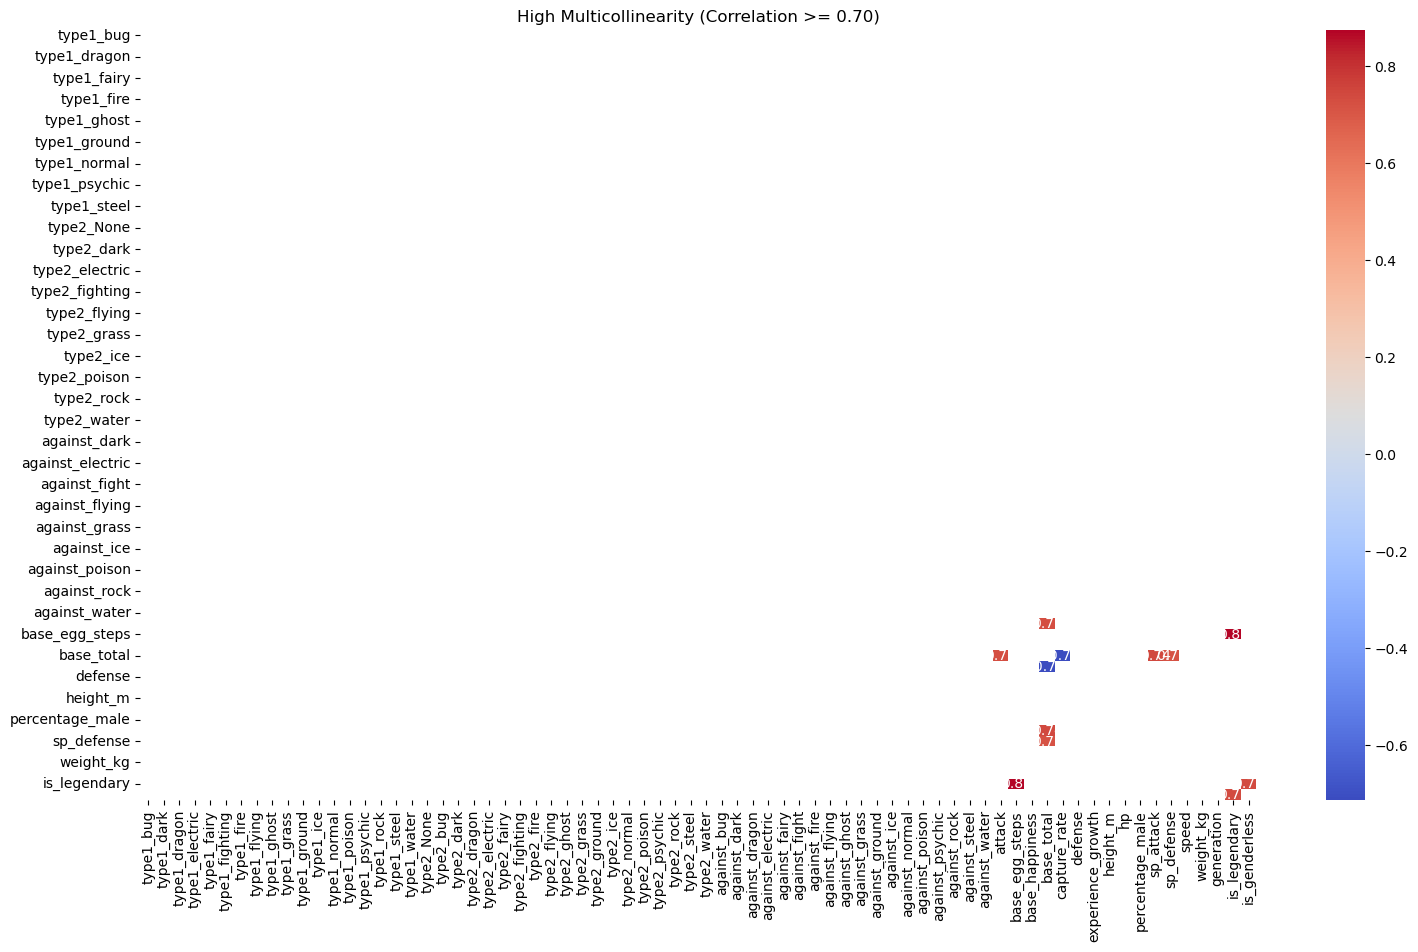

In [7]:
corr_matrix = encoded_data.corr()

# Set a threshold for high multicollinearity 
threshold = 0.7

# Create a mask to filter out lower correlated values
mask = abs(corr_matrix) >= threshold

# Set the diagonal elements to False to avoid showing self-correlations
np.fill_diagonal(mask.values, False)

# Plot the filtered correlation matrix as a heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix[mask], cmap='coolwarm', annot=True, fmt='.2f')
plt.title('High Multicollinearity (Correlation >= {:.2f})'.format(threshold))
plt.show()

The regular correlation heatmap doesnt display the correlations between many variables that clearly (as seen below). To address this issue, I have chosen to use the corr_simple function with a sigmoid/threshold level equal to or more than 0.7. The corr_simple function calculates and identifies significant correlations, which reduces clutter in the resulting visualization. I adapted the code below from Catherine Williams, who originally wrote it for R: [article here](https://towardsdatascience.com/how-to-create-a-correlation-matrix-with-too-many-variables-309cc0c0a57)

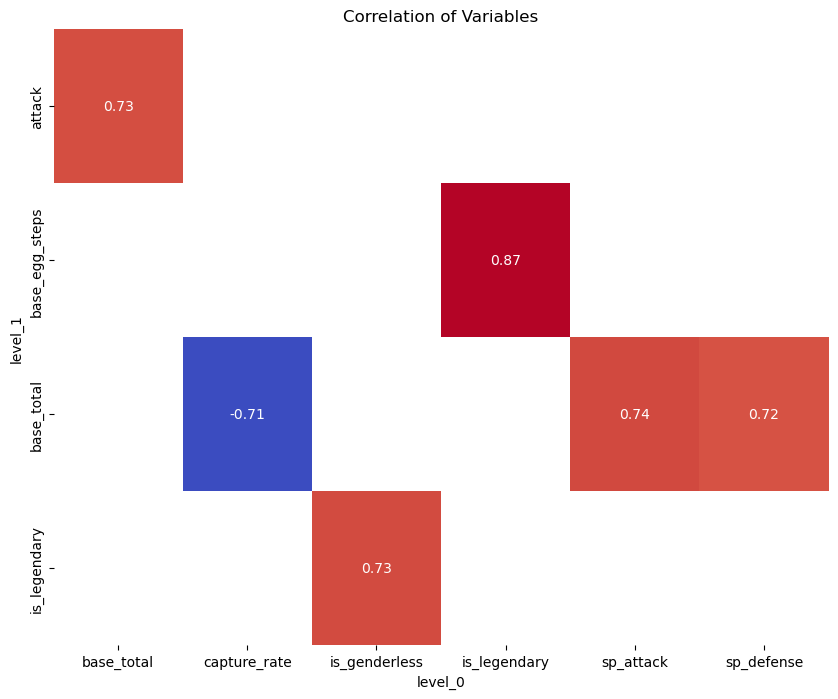

            level_0         level_1         0
5096   is_legendary  base_egg_steps  0.873488
4738      sp_attack      base_total  0.741120
5182  is_genderless    is_legendary  0.734375
4231     base_total          attack  0.730134
4810     sp_defense      base_total  0.717434
4306   capture_rate      base_total -0.712275


In [8]:
def corr_simple(data, sig=0.7):

    # Run a correlation and drop the insignificant ones
    corr = encoded_data.corr()
    
    # Prepare to drop duplicates and correlations of 1
    corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # Drop perfect correlations
    corr[corr == 1] = np.nan
    
    # Remove the NA values from above
    corr = corr.unstack().reset_index()
    corr = corr.dropna(subset=[0])
    
    # Select significant values
    corr = corr[abs(corr[0]) > sig]
    
    # Sort by highest correlation
    corr = corr.sort_values(by=0, ascending=False)
    
    # Plot correlations visually
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr.pivot(index='level_1', columns='level_0', values=0),
                annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
    plt.title('Correlation of Variables')
    plt.show()
    
    return corr

# A table to complement the heatmap:
resulting_corr_table = corr_simple(data)
print(resulting_corr_table)

Based on the correlation heatmap above, we can see that there is evidence of multicollinearity between **sp_attack**, **sp_defense**,**attack** with **base_total** (sigmoid/threshold <=0.7).

**is_genderless** has a strong correlation with is_legendary, but since is_genderless is an explanatory/independent variable and is_legendary is a target/dependent variable, this does not constitute multicollinearity (multicollinearity is a strong correlation between two or more independent variables). 

We can further confirm their impact on the model using a Variance Inflation Factor (VIF) Analysis. 

In [9]:
# Correlations between Numerical Features and Legendary Status

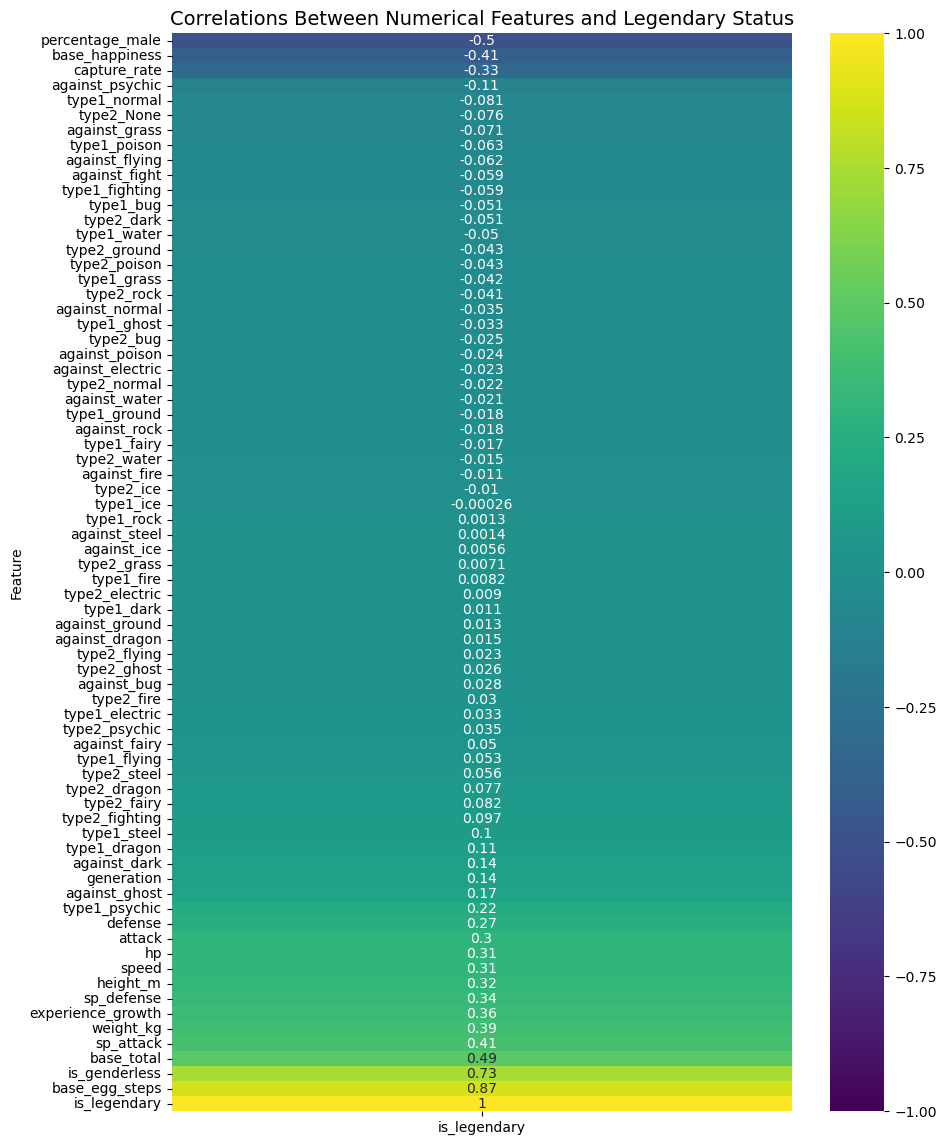

In [10]:
correlation_matrix = encoded_data.corr()[['is_legendary']].sort_values('is_legendary')
plt.figure(figsize=(10, 14))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = 'viridis')
plt.title('Correlations Between Numerical Features and Legendary Status', fontdict={'fontsize':14})
plt.ylabel('Feature');



In [11]:
#The results confirm what we've already seen in the heatmap above, especially with regads to is_legendary

In [12]:
#Variance Inflation Factor

In [13]:
#Using VIF, we can measure the level of collinearity between variables. This is particularly pertinent as later on I will be performing a logistic regression as as part of my binary classification model building

In [14]:
# Step 1: Select all predictor variables (excluding the target variable) for VIF calculation
predictor_variables = encoded_data.drop(columns=['is_legendary'])  # 'is_legendary' is the target variable

# Step 2: Add a constant term to the predictor variables
predictor_variables = sm.add_constant(predictor_variables)

# Step 3: Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictor_variables.columns
vif["VIF"] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

vif

,Variable,VIF
0,const,0.000000
1,type1_bug,inf
2,type1_dark,inf
3,type1_dragon,inf
4,type1_electric,inf
5,type1_fairy,inf
6,type1_fighting,inf
7,type1_fire,inf
8,type1_flying,inf
9,type1_ghost,inf


**type1_() and type2_()** encoded variables have extremely high VIF values of inf(infinity), which indicate perfect collinearity. To examine the effects of the type_? variables on the VIF, let's first drop all encoded type2 variables and then rerun the VIF analysis. Note: **const** is an intercept term that is necessary for the VIF calculation, and not an actual variable.

In [15]:
#Let's drop all encoded type2 variables and rerun the VIF again
predictor_variables = encoded_data.drop(columns=['is_legendary', *encoded_data.filter(like='type2_').columns])

# Step 2: Add a constant term to the predictor variables (if needed for your specific use case)
# predictor_variables = sm.add_constant(predictor_variables)

# Step 3: Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictor_variables.columns
vif["VIF"] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

# Step 4: Display the table with VIF values
print(vif)

             Variable        VIF
0           type1_bug  63.961603
1          type1_dark  23.740760
2        type1_dragon  25.915293
3      type1_electric  34.876063
4         type1_fairy  15.582224
5      type1_fighting  26.398785
6          type1_fire  45.471177
7        type1_flying   3.809306
8         type1_ghost  19.583977
9         type1_grass  69.224574
10       type1_ground  28.021126
11          type1_ice  24.084049
12       type1_normal  87.168249
13       type1_poison  28.675335
14      type1_psychic  51.710545
15         type1_rock  40.982493
16        type1_steel  18.718590
17        type1_water  96.162909
18        against_bug   5.606412
19       against_dark  17.806473
20     against_dragon   9.961048
21   against_electric   5.758746
22      against_fairy   7.593499
23      against_fight   6.117509
24       against_fire   8.604665
25     against_flying   8.107154
26      against_ghost  26.874753
27      against_grass   4.820987
28     against_ground   6.490553
29        

In [16]:
# The degree of collinearity among variables seeems to have gone down, but still remains high among type1_() variables (VIF>5). Both type1_() and type2_() variables are also represented by their 'opposite' variables (i.e Water pokemon would have high against_fire values), so dropping them doesn't mean losing their interpretation completely. Let's drop that too and rerun the VIF analysis.

In [17]:
# Step 1: Select all predictor variables (excluding the target variable) for VIF calculation
predictor_variables = encoded_data.drop(columns=['is_legendary'])  # 'is_legendary' is the target variable

# Step 2: Drop the 'type1_' and 'type2_' variables
type1_columns = [col for col in predictor_variables.columns if col.startswith('type1_')]
type2_columns = [col for col in predictor_variables.columns if col.startswith('type2_')]
predictor_variables = predictor_variables.drop(columns=type1_columns + type2_columns)

# Step 3: Add a constant term to the predictor variables
predictor_variables = sm.add_constant(predictor_variables)

# Step 4: Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictor_variables.columns
vif["VIF"] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

# Step 5: Display the table with VIF values
print(vif)

             Variable         VIF
0               const  435.954392
1         against_bug    3.829944
2        against_dark    5.068283
3      against_dragon    5.598632
4    against_electric    4.070857
5       against_fairy    4.210338
6       against_fight    4.381383
7        against_fire    5.626445
8      against_flying    4.996092
9       against_ghost    4.497346
10      against_grass    2.254786
11     against_ground    4.908449
12        against_ice    2.744434
13     against_normal    2.698507
14     against_poison    4.176391
15    against_psychic    4.324648
16       against_rock    4.215901
17      against_steel    2.422797
18      against_water    3.620668
19             attack         inf
20     base_egg_steps    2.747927
21     base_happiness    1.733569
22         base_total         inf
23       capture_rate    2.285400
24            defense         inf
25  experience_growth    1.287435
26           height_m    2.084226
27                 hp         inf
28    percenta

In [18]:
# Once again, the degree of collinearity among variables seems to have gone down, but still remains high among these variables: sp_attack', 'sp_defense', 'speed', 'defense', and 'attack'. From the perspective of domain knowledge alone, base_total serves as a representation of all these variables so we can do without them. Let's drop all of them and rerun the VIF analysis again.

In [19]:
# Step 1: Select all predictor variables (excluding the target variable) for VIF calculation
predictor_variables = encoded_data.drop(columns=['is_legendary'])  # 'is_legendary' is the target variable

# Step 2: Drop the 'type1_' and 'type2_' variables
type1_columns = [col for col in predictor_variables.columns if col.startswith('type1_')]
type2_columns = [col for col in predictor_variables.columns if col.startswith('type2_')]
predictor_variables = predictor_variables.drop(columns=type1_columns + type2_columns)

# Step 3: Drop additional variables 'sp_attack', 'sp_defense', 'speed', 'defense', and 'attack'
predictor_variables = predictor_variables.drop(columns=['sp_attack', 'sp_defense', 'speed', 'defense', 'attack'])

# Step 4: Add a constant term to the predictor variables
predictor_variables = sm.add_constant(predictor_variables)

# Step 5: Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = predictor_variables.columns
vif["VIF"] = [variance_inflation_factor(predictor_variables.values, i) for i in range(predictor_variables.shape[1])]

# Step 6: Display the table with VIF values
print(vif)


             Variable         VIF
0               const  432.238969
1         against_bug    3.791868
2        against_dark    4.966388
3      against_dragon    5.465743
4    against_electric    4.000522
5       against_fairy    4.138769
6       against_fight    4.349238
7        against_fire    5.499595
8      against_flying    4.905507
9       against_ghost    4.441880
10      against_grass    2.183333
11     against_ground    4.756839
12        against_ice    2.672032
13     against_normal    2.620034
14     against_poison    4.078850
15    against_psychic    4.268641
16       against_rock    3.980861
17      against_steel    2.365146
18      against_water    3.506147
19     base_egg_steps    2.740824
20     base_happiness    1.720574
21         base_total    3.118121
22       capture_rate    2.267305
23  experience_growth    1.271994
24           height_m    2.078829
25                 hp    2.078951
26    percentage_male    2.313043
27          weight_kg    2.052670
28         gen

In [20]:
# Now, all variables seem to have VIF scores within the acceptable limit (VIF<5). There are some variables with VIF scores marginally above 5, but deleting just one of a set (for example, against_dragon or again_fire from the against_() set), would affect the interpretability of the remaining variables. I'll need to see more evidence before I'm willing to drop them.

In [21]:
# Summary of Correlation and VIF analysis



| Group 1         | Group 2         | Correlation Value |
|-----------------|-----------------|-------------------|
| against_dark    | against_psychic | 0.538784          |
| against_dragon  | type1_dragon    | 0.545864          |
| against_flying  | against_fire    | 0.528127          |
| against_ghost   | against_dark    | 0.672337          |
| against_ghost   | against_fight   | -0.546982         |
| against_ghost   | type1_normal    | -0.685760         |
| against_grass   | type1_water     | 0.535366          |
| against_ground  | type2_flying    | -0.545502         |
| against_poison  | type1_grass     | 0.520960          |
| against_rock    | type2_flying    | 0.594236          |
| against_electric| type1_water     | 0.516257          |
| base_happiness  | base_egg_steps  | -0.524551         |
| base_total      | attack          | 0.730134          |
| base_total      | defense         | 0.629620          |
| base_total      | hp              | 0.620624          |
| base_total      | sp_attack       | 0.741120          |
| base_total      | sp_defense      | 0.717434          |
| capture_rate    | base_total      | -0.712275         |
| is_genderless   | base_egg_steps  | 0.681136          |         |
| is_genderless   | percentage_male | -0.689832         |
| sp_attack       | capture_rate    | -0.520682         |
| sp_defense      | capture_rate    | -0.522616         |
| sp_defense      | defense         | 0.526348          |
| sp_defense      | sp_attack       | 0.511496          |
| speed           | base_total      | 0.547666          |
| weight_kg       | height_m        | 0.626516          |




| Variable         | Correlation with "is_legendary" |
|------------------|---------------------------------|
| base_total       | 0.734375                        |
| is_genderless    | 0.734375                        |
| attack           | 0.730134                        |
| sp_attack        | 0.741120                        |
| sp_defense       | 0.717434                        |
| height_m         | 0.533655                        |
| capture_rate     | -0.522616                       |
| percentage_male  | -0.689832                       |
| base_happiness   | -0.524551                       |

These variables have correlations with the "is_legendary" target variable, which indicates their potential importance in distinguishing legendary Pokémon from non-legendary ones. Positive correlations suggest that the variables increase with the likelihood of being legendary, while negative correlations suggest that the variables decrease with the likelihood of being legendary.

In [22]:
# Dropping columns based on domain knowledge



| **Column Name**       | **Description**                                                 |
|-----------------------|-----------------------------------------------------------------|
| name                  | The English name of the Pokemon                                |
| japanese_name         | The Original Japanese name of the Pokemon                      |
| pokedex_number        | The entry number of the Pokemon in the National Pokedex        |
| percentage_male       | The percentage of the species that are male. Blank if the Pokemon is genderless. |
| type1                 | The Primary Type of the Pokemon                                 |
| type2                 | The Secondary Type of the Pokemon                               |
| classification        | The Classification of the Pokemon as described by the Sun and Moon Pokedex |
| height_m              | Height of the Pokemon in metres                                 |
| weight_kg             | The Weight of the Pokemon in kilograms                          |
| capture_rate          | Capture Rate of the Pokemon                                     |
| base_egg_steps        | The number of steps required to hatch an egg of the Pokemon     |
| abilities             | A stringified list of abilities that the Pokemon is capable of having |
| experience_growth     | The Experience Growth of the Pokemon                            |
| base_happiness        | Base Happiness of the Pokemon                                   |
| against_?             | Eighteen features that denote the amount of damage taken against an attack of a particular type |
| hp                    | The Base HP of the Pokemon                                      |
| attack                | The Base Attack of the Pokemon                                  |
| defense               | The Base Defense of the Pokemon                                 |
| sp_attack             | The Base Special Attack of the Pokemon                          |
| sp_defense            | The Base Special Defense of the Pokemon                         |
| speed                 | The Base Speed of the Pokemon                                   |
| generation            | The numbered generation which the Pokemon was first introduced  |
| is_legendary          | Denotes if the Pokemon is legendary                             |



**base_egg_steps**: I will be dropping this column as legendary pokemon are generally unable to breed.

**name**: Names are not essential to model training and development. However, I will create a dictionary that maps the pokedex_number/index to the pokemon name to be used in further projects.

**japanese_name** : Names are not essential to model training and development.
    
**classification** : There are 588 unique, **descriptive/nominal** classifications (etc. Seed Pokemon, Dog Pokemon) and there are only 801 pokemon. This means there is unlikely any value in comparison.
    
**abilties**: String descriptions of abilities. It can be dropped for the same reason as **classification**.



In [23]:
data.drop(columns=['speed','defense','attack', 'sp_attack', 'sp_defense', 'type1', 'type2', 'base_egg_steps', 'base_happiness', 'name', 'japanese_name', 'abilities', 'classification'], inplace=True)
#dropped_columns = data[[ 'speed','defense','attack', 'sp_attack', 'sp_defense', 'type1', 'type2', 'base_egg_steps', 'base_happiness', 'name', 'japanese_name', 'abilities', 'classification']] #to be done all at once at the end because I can only do it once


In [24]:
data.info() # confirming that they have been dropped from the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        801 non-null    float64
 1   against_dark       801 non-null    float64
 2   against_dragon     801 non-null    float64
 3   against_electric   801 non-null    float64
 4   against_fairy      801 non-null    float64
 5   against_fight      801 non-null    float64
 6   against_fire       801 non-null    float64
 7   against_flying     801 non-null    float64
 8   against_ghost      801 non-null    float64
 9   against_grass      801 non-null    float64
 10  against_ground     801 non-null    float64
 11  against_ice        801 non-null    float64
 12  against_normal     801 non-null    float64
 13  against_poison     801 non-null    float64
 14  against_psychic    801 non-null    float64
 15  against_rock       801 non-null    float64
 16  against_steel      801 non

In [25]:
#Variable Distribution Visualizer

In [26]:
#Outliers - left intact as they represent rare and extraordinary attributes

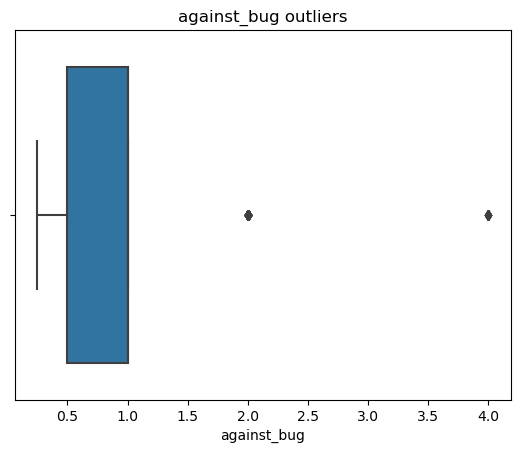

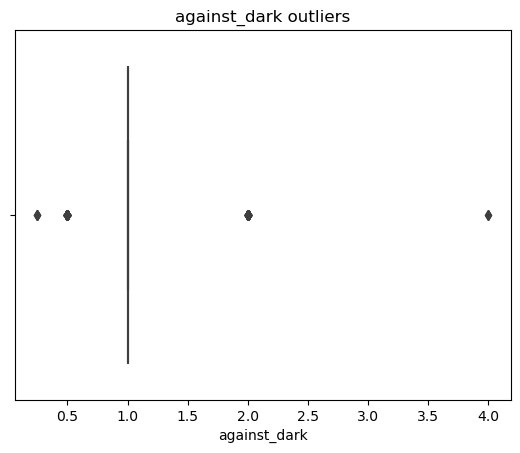

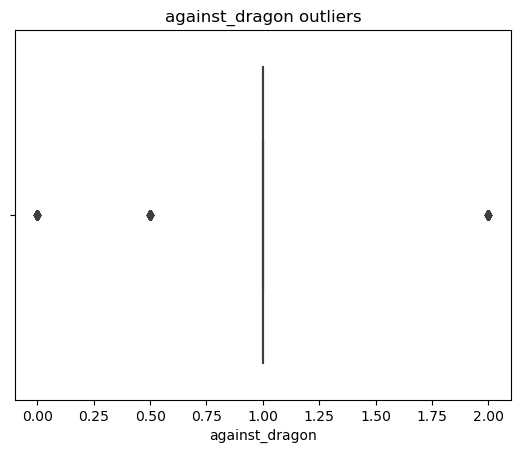

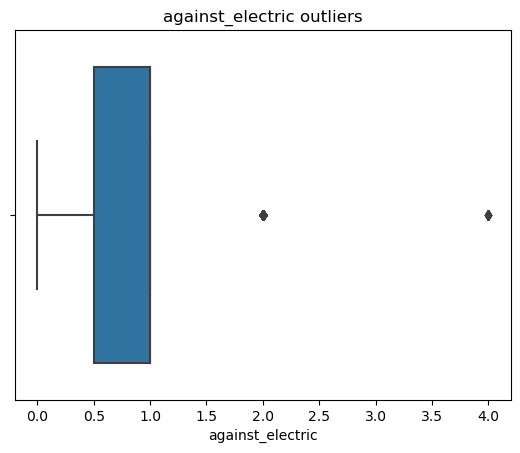

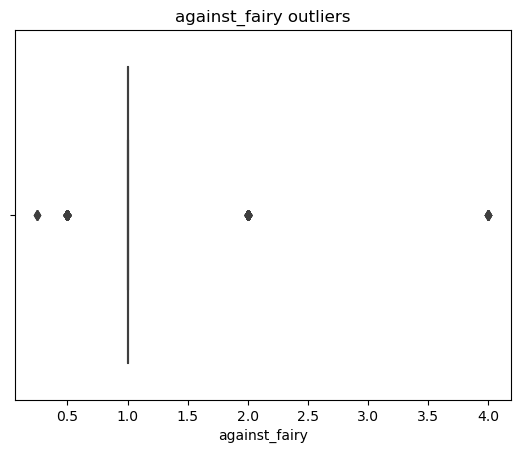

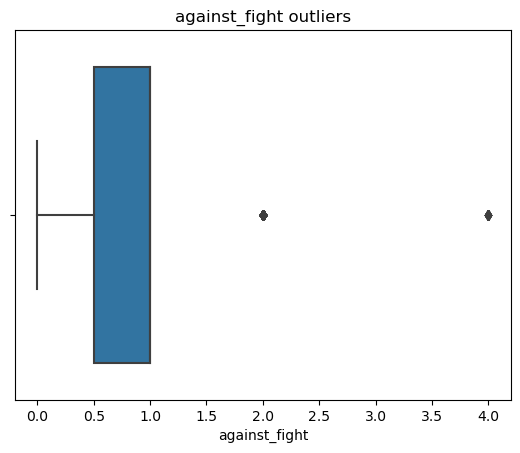

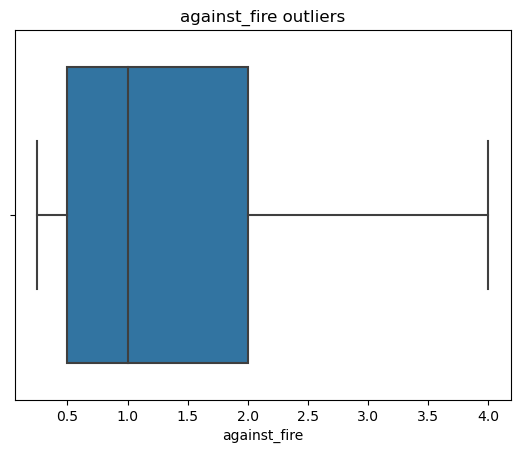

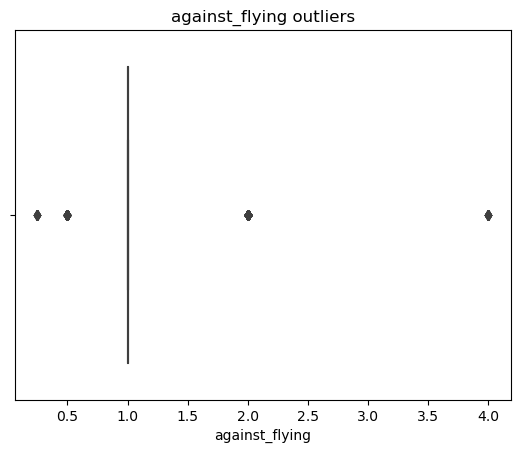

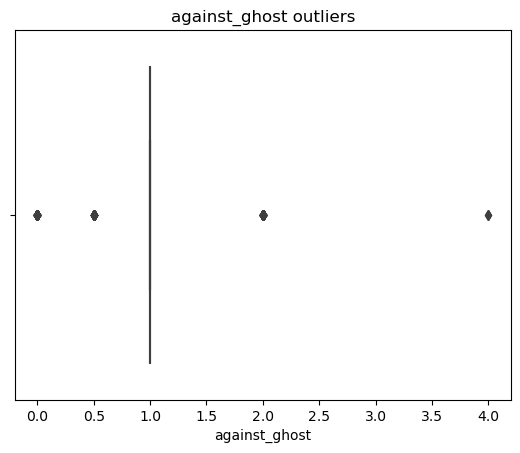

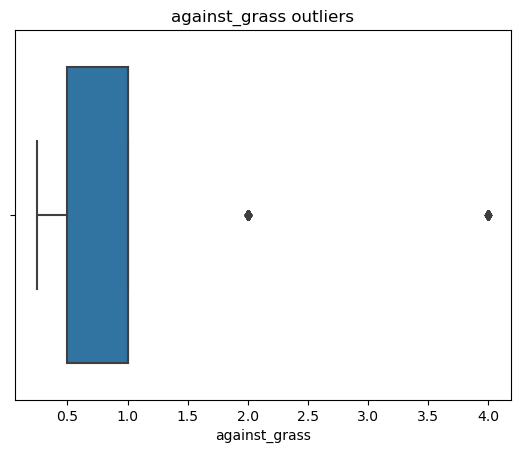

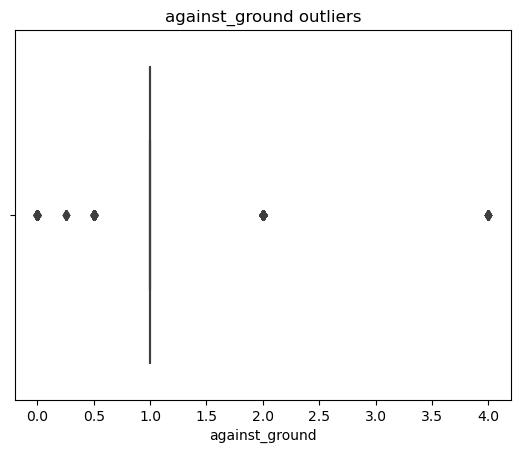

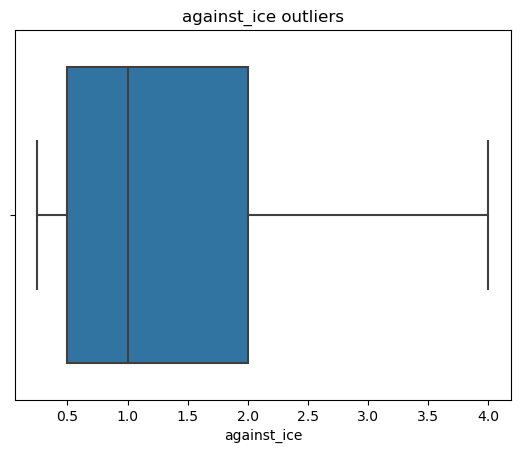

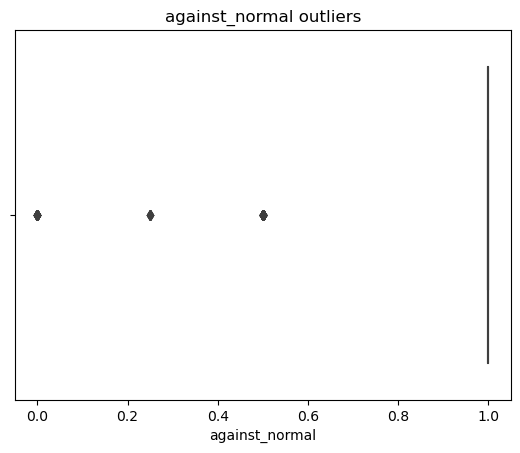

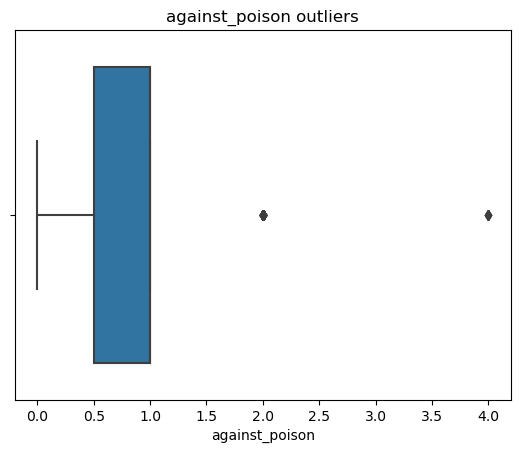

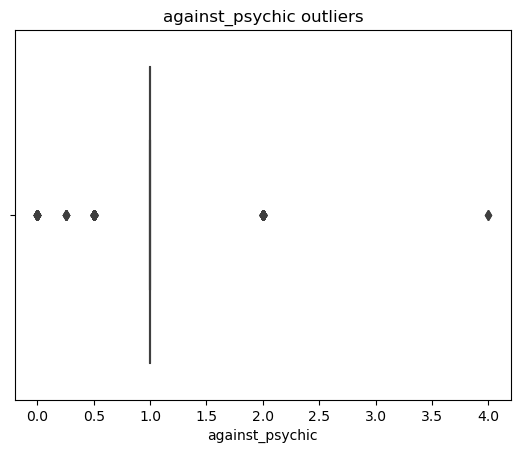

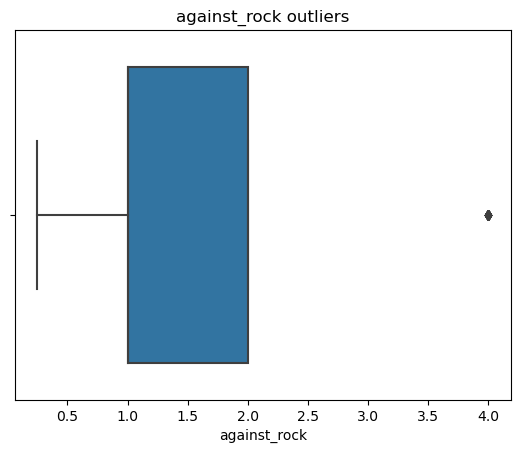

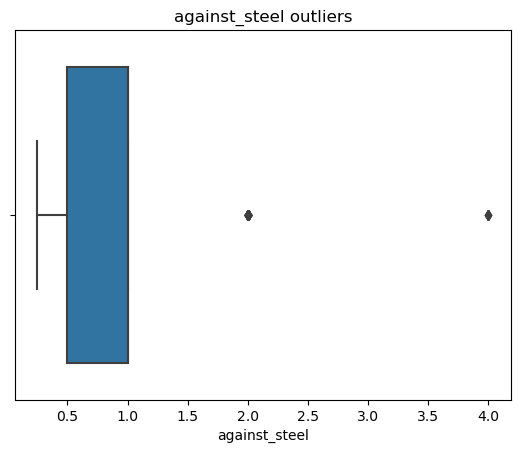

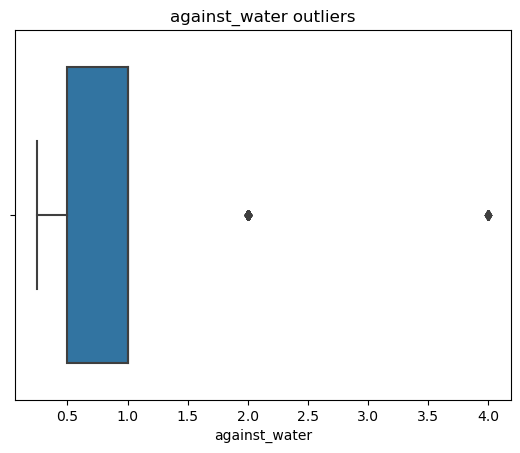

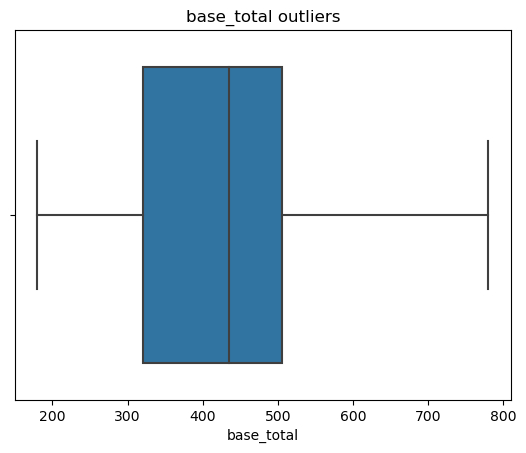

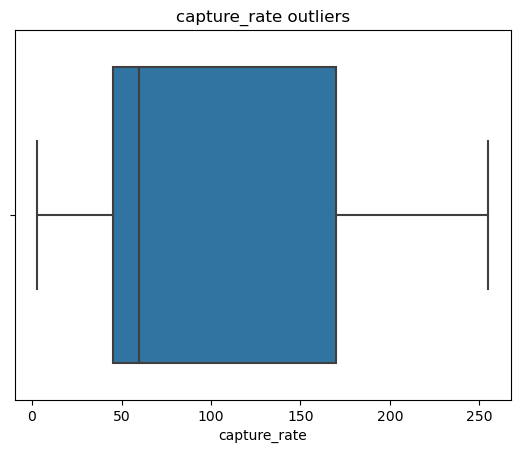

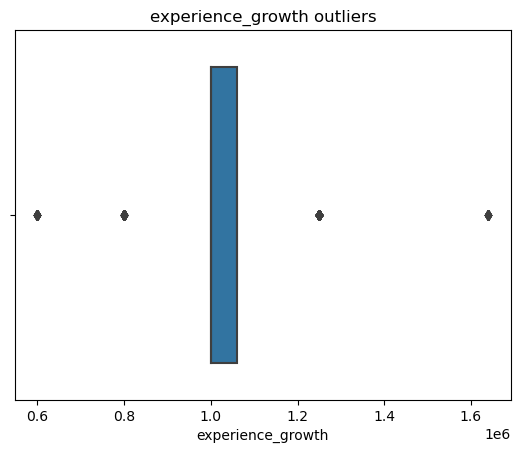

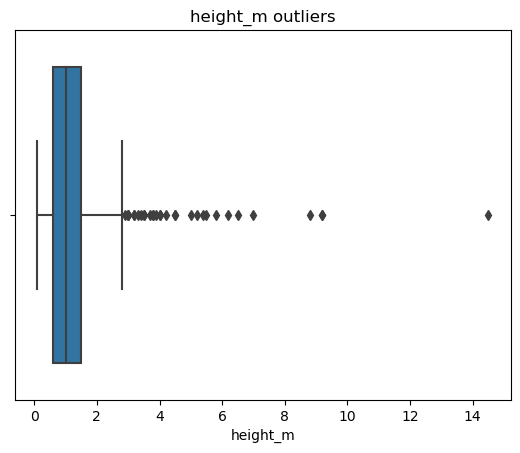

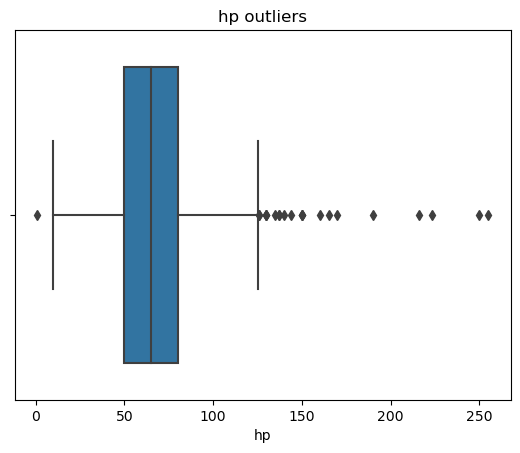

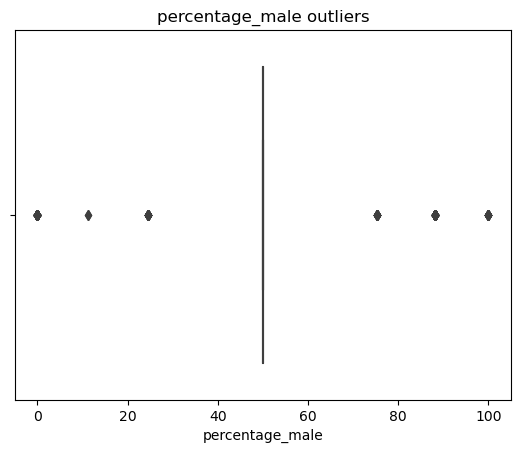

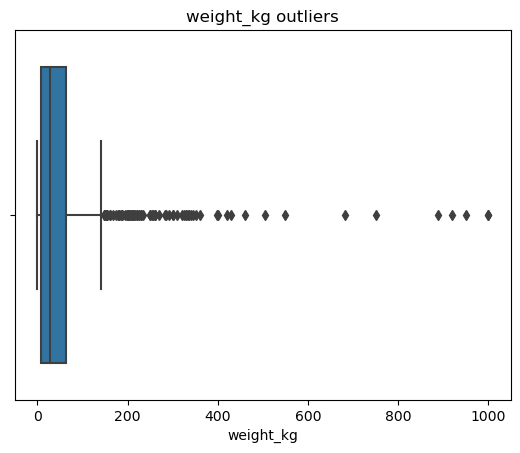

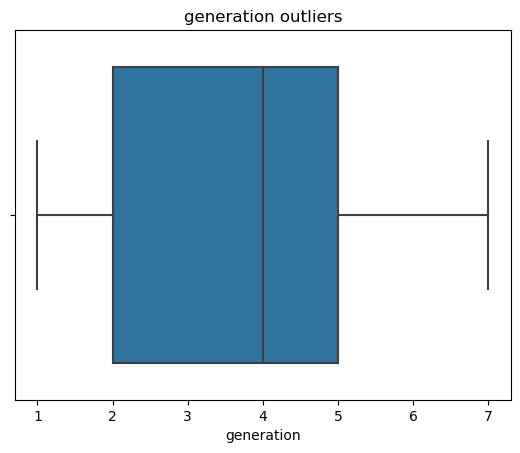

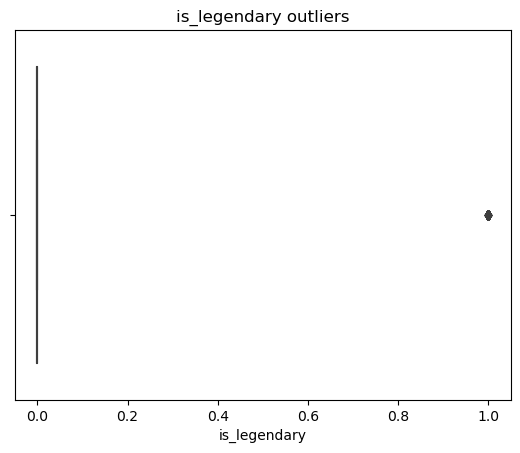

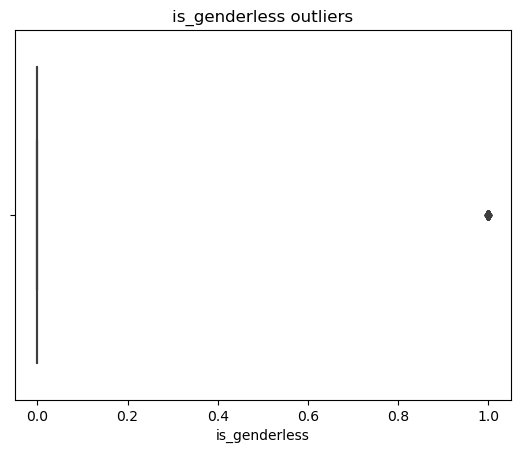

In [27]:
# Create a boxplot for each column in the dataframe
for col in data.columns:
    plt.figure()
    sns.boxplot(x=data[col])
    plt.title(col + " outliers")

### Variable Variance - dropping constant variables and variables with extremely low variance (quasi-constant), as Support Vector Machine models are sensitive to low variance variables

#### A simple loop to filter our zero variance or low variance variables based on a variance threshold. [Credits to Shelvi Garg for the code](https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9)

In [28]:
var_thr= VarianceThreshold(threshold=0.0) #this means 100% of all values within the column are the same, in other words constant/zero variance variable
var_thr.fit(data)

var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [29]:
concol = [column for column in data.columns 
          if column not in data.columns[var_thr.get_support()]]

for features in concol:
    print(features)

In [30]:
#As the function returns nothing, that means there are no constant/zero variance variables.

#### I have decided to benchmark the variance threshold to the ratio of legendary pokemon to the total pokemon in the dataset, which is 70/801. [There is no hard and fast rule on setting variance thresholds](https://scikit-learn.org/stable/modules/feature_selection.html) but I believe it takes into account the significant imbalance between the minority and the majority target class.

In [31]:
var_thr= VarianceThreshold(threshold=(70/801)) # 70/801= 0.0873, and that means at least 87.3% of all values within the column are the same
var_thr.fit(data)

var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [32]:
concol = [column for column in data.columns 
          if column not in data.columns[var_thr.get_support()]]

for features in concol:
    print(features)

against_normal
is_legendary


In [33]:
var_thr= VarianceThreshold(threshold=0.09) # that means at least 90% of all values within the column are the same
var_thr.fit(data)
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [34]:
concol = [column for column in data.columns 
          if column not in data.columns[var_thr.get_support()]]

for features in concol:
    print(features)

against_normal
is_legendary


In [35]:
# is_legendary can't be dropped as it is the target variable, but we most certainly can drop against_normal --at least 90% of all its values are the same!!!

In [36]:
data.drop(columns=['against_normal'])
data.info() # to confirm that against_normal has been dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        801 non-null    float64
 1   against_dark       801 non-null    float64
 2   against_dragon     801 non-null    float64
 3   against_electric   801 non-null    float64
 4   against_fairy      801 non-null    float64
 5   against_fight      801 non-null    float64
 6   against_fire       801 non-null    float64
 7   against_flying     801 non-null    float64
 8   against_ghost      801 non-null    float64
 9   against_grass      801 non-null    float64
 10  against_ground     801 non-null    float64
 11  against_ice        801 non-null    float64
 12  against_normal     801 non-null    float64
 13  against_poison     801 non-null    float64
 14  against_psychic    801 non-null    float64
 15  against_rock       801 non-null    float64
 16  against_steel      801 non

### Feature Importance [Credits to Noa Azaria for the code](https://www.aporia.com/learn/feature-importance/feature-importance-7-methods-and-a-quick-tutorial/) and [Brian Roepke for further insturction!](https://www.dataknowsall.com/featureselection.html)

In [37]:
data1= data.copy()

In [38]:
# Separate features and target
X = data1.drop(columns=['is_legendary'])
y = data1['is_legendary']

In [39]:
# Initialize the Random Forest Classifier model
rf_model=RandomForestClassifier(random_state=42, n_jobs=None, class_weight='balanced')

              Feature  Importance
18         base_total    0.218110
23    percentage_male    0.197402
19       capture_rate    0.140518
20  experience_growth    0.133764
26      is_genderless    0.130741
22                 hp    0.052649
21           height_m    0.033076
24          weight_kg    0.021485
25         generation    0.012537
14    against_psychic    0.006975
1        against_dark    0.006101
8       against_ghost    0.005869
5       against_fight    0.005535
11        against_ice    0.003844
10     against_ground    0.003553
0         against_bug    0.003507
16      against_steel    0.003204
7      against_flying    0.003081
9       against_grass    0.002887
4       against_fairy    0.002854
3    against_electric    0.002570
13     against_poison    0.002541
2      against_dragon    0.002188
15       against_rock    0.001818
6        against_fire    0.001429
17      against_water    0.001180
12     against_normal    0.000580


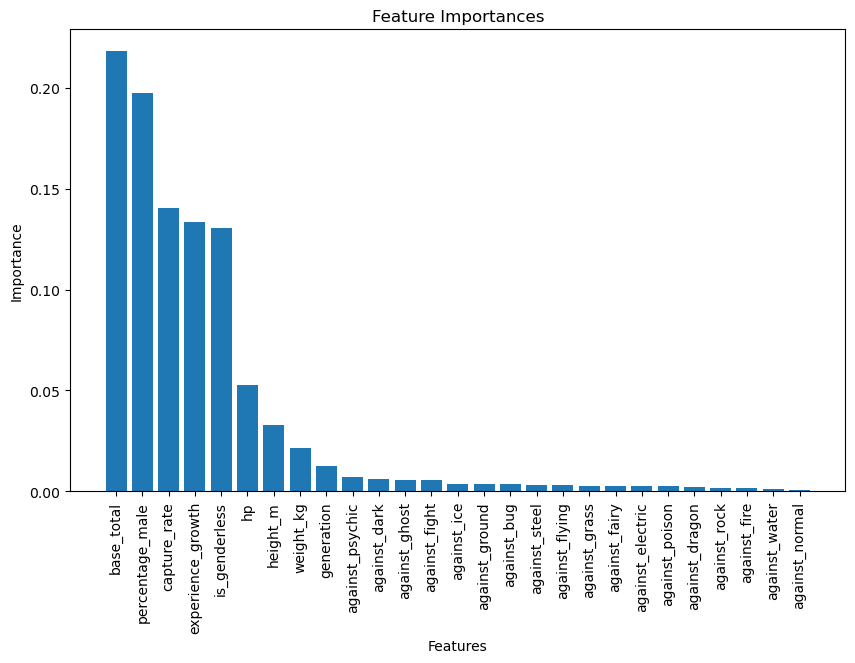

In [40]:
# Let's fit the model
rf_model.fit(X,y)

# ...And obtain the feature importances
feature_importances= pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualize the feature importances with a sassy bar plot (after printing a table)
print(feature_importances)
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()



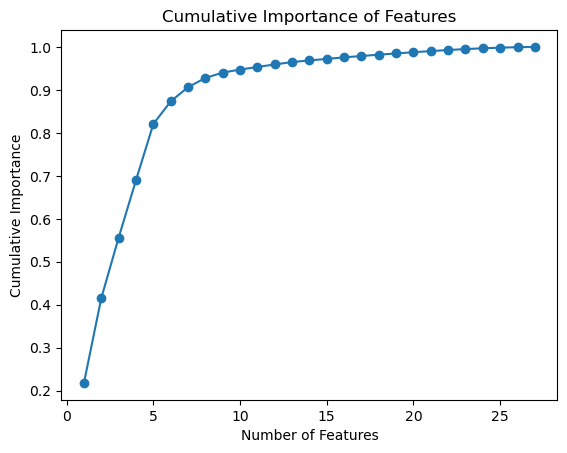

In [41]:
cumulative_importance = feature_importances['Importance'].cumsum()

# Plot the cumulative sum of feature importances
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importance of Features')
plt.show()

In [42]:
# From the table and bar chart, it appears that all variables after 'generation' have significantly diminishing feature importance to the model. To cross validate, I made a culmulative line plot to see where the 'elbow' would be. The plot supports the conclusion ideal number of features is between 7-9, and the variable 'generation' happens to be the 9th. Thus we can drop all against_() variables from the dataframe. However, i might still reverse this process at the end if the performance of the model suffers. 

In [64]:
data.drop(columns=['against_psychic', 'against_dark', 'against_ghost', 'against_fight','against_ice', 'against_ground', 'against_bug', 'against_steel','against_flying', 'against_grass', 'against_fairy', 'against_electric','against_poison', 'against_dragon', 'against_rock', 'against_fire','against_water', 'against_normal'], inplace=True)

In [65]:
data.to_csv('pokemon_cleaned.csv', index=False)